**Names**: Natalia García Sánchez and Ana Solbas Casajús

In [1]:
#Install rdkit

!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -c rdkit rdkit

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:31
🔁 Restarting kernel...
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

In [1]:
# libraries
import json  # lets us work with the json format
import requests  # allows Python to make web requests
import pandas as pd # analysis of tabular data
import numpy as np # numerical library

In [2]:
import rdkit.Chem.AllChem as AllChem # rdkit. chemoinformatics
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
import math
import matplotlib.pyplot as plt

# Finding known drugs and molecules that interact with JAK proteins using programatic acces to ChEMBL (RESTful interface) and Ligand Based Virtual Screening (LBVS)


## Query molecule selection

Small-molecule inhibitors of Janus Kinase (JAK) enzymes have been studied for the treatment or rheumatoid arthritis (RA) and some of them have been approved for commercialization. The objective of this project is to find molecules that could be potential drugs for the treatment of RA. 

The JAK protein family of intracellular enzymes is made up by four proteins: JAK1, JAK2, JAK3 and TYK2. We would like to find a drug that can act as an inhibitor of the activity of these proteins. 

First of all, we did a search in the **UniProt** database to obtain the accession number of the **JAK1** protein. Its accession number is P23458.

Now, we are going to find in the ChEMBL database all the molecules that can interact with this protein, so we can find an inhibitor that can be used as a query molecule for the Ligand Based Virtual Screening. 

In [3]:
BASE_URL = "https://www.ebi.ac.uk/chembl/api/data/{:s}"
#Find protein in the ChEMBL database
target_protein_url = BASE_URL.format("target_component?accession=P23458")
target_components = requests.get(target_protein_url, headers={"Accept":"application/json"}).json()['target_components']
target_components[0]['targets']

[{'target_chembl_id': 'CHEMBL2835'},
 {'target_chembl_id': 'CHEMBL2363062'},
 {'target_chembl_id': 'CHEMBL3038491'},
 {'target_chembl_id': 'CHEMBL3038492'},
 {'target_chembl_id': 'CHEMBL3301390'},
 {'target_chembl_id': 'CHEMBL3301391'},
 {'target_chembl_id': 'CHEMBL4630751'},
 {'target_chembl_id': 'CHEMBL4742275'}]

We're going to filter all the targets obtained by *target_type* as we are interesed in the protein family of JAK  proteins. 

In [4]:
targets_list = ';'.join([i['target_chembl_id'] for i in target_components[0]['targets']])
targets_url = BASE_URL.format("target/set/{:s}".format(targets_list))
targets = requests.get(targets_url, headers={"Accept":"application/json"}).json()

In [5]:
for i in targets['targets']:
    print(i['target_chembl_id'], i['target_type'])

CHEMBL2835 SINGLE PROTEIN
CHEMBL2363062 PROTEIN FAMILY
CHEMBL3038491 PROTEIN COMPLEX
CHEMBL3038492 PROTEIN COMPLEX
CHEMBL3301390 PROTEIN COMPLEX
CHEMBL3301391 PROTEIN COMPLEX
CHEMBL4630751 PROTEIN-PROTEIN INTERACTION
CHEMBL4742275 PROTEIN-PROTEIN INTERACTION


The protein faimily is identified by the **CHEMBL2363062** ID. 

Once we have identified the **JAK** family in the ChEMBL database, we are going to identify molecules that are related to this target. There are two ways of achieving this: 

- Finding assays related to the protein
- Finding approved drugs

### 1) Finding Assay Data

First, we are going to find all the compounds associated with the JAK protein family as a target as some drugs has activity against several proteins of the family, which have some domains conserved.

In [6]:
activity_url = BASE_URL.format ("activity?target_chembl_id__exact=CHEMBL2363062&offset=0&limit=0")
activity_request = requests.get(activity_url, headers={"Accept":"application/json"}).json()

In [7]:
# Transform data in a table and show the chembl code, the classification of the compund, the standard value and units. Complete the code
activity_table = pd.DataFrame.from_dict(activity_request['activities'])[['molecule_chembl_id', 'type', 'standard_value', 'units']]
activity_table

,molecule_chembl_id,type,standard_value,units
0,CHEMBL1213000,INH,None,None
1,CHEMBL487996,INH,None,None
2,CHEMBL1212997,INH,25.0,%
3,CHEMBL509617,INH,25.0,%
4,CHEMBL338474,INH,25.0,%
...,...,...,...,...
158,CHEMBL4750845,INH,None,None
159,CHEMBL4750845,INH,None,None
160,CHEMBL4750845,IC50,12100.0,uM
161,CHEMBL4750845,IC50,5000.0,uM


In [8]:
#We select only those that have IC50
activity_table_filter = activity_table.loc[activity_table['type']=="IC50"].copy().dropna()
#Transform the standard_value column to float to be able to work with it
activity_table_filter['standard_value'] = activity_table_filter['standard_value'].astype("float")
#And we order the table by value
activity_table_filter.sort_values(['standard_value']).head(10)

,molecule_chembl_id,type,standard_value,units
145,CHEMBL4764019,IC50,2.8,nM
144,CHEMBL4742159,IC50,3.3,nM
124,CHEMBL4740778,IC50,4.0,nM
53,CHEMBL4093813,IC50,4.5,nM
119,CHEMBL4777342,IC50,4.7,nM
65,CHEMBL3979355,IC50,5.0,nM
125,CHEMBL4793262,IC50,5.0,nM
118,CHEMBL4744172,IC50,5.2,nM
155,CHEMBL4745474,IC50,6.4,nM
49,CHEMBL4078165,IC50,9.1,nM


### 2) Search for Approved Drugs

In [9]:
mechanism_url = "https://www.ebi.ac.uk/chembl/api/data/mechanism?target_chembl_id__exact=CHEMBL2363062&offset=0&limit=0"
mechanism_request = requests.get(mechanism_url, headers={"Accept":"application/json"}).json()
mechanism_table = pd.DataFrame.from_dict(mechanism_request['mechanisms'])[['molecule_chembl_id', 'parent_molecule_chembl_id', 'target_chembl_id', 'selectivity_comment', 'max_phase']]
mechanism_table

,molecule_chembl_id,parent_molecule_chembl_id,target_chembl_id,selectivity_comment,max_phase
0,CHEMBL2103743,CHEMBL221959,CHEMBL2363062,None,4
1,CHEMBL3137308,CHEMBL3137308,CHEMBL2363062,None,3
2,CHEMBL3622821,CHEMBL3622821,CHEMBL2363062,"In vitro, higher activity against JAK1 and JAK...",4
3,CHEMBL4297507,CHEMBL4297507,CHEMBL2363062,Selective for the JAK family over LCK members....,3
4,CHEMBL4594275,CHEMBL4594275,CHEMBL2363062,None,2
5,CHEMBL4650343,CHEMBL4650343,CHEMBL2363062,None,2


In [10]:
approved_drug_id = mechanism_table[mechanism_table['max_phase']==4]
approved_drug_id

,molecule_chembl_id,parent_molecule_chembl_id,target_chembl_id,selectivity_comment,max_phase
0,CHEMBL2103743,CHEMBL221959,CHEMBL2363062,None,4
2,CHEMBL3622821,CHEMBL3622821,CHEMBL2363062,"In vitro, higher activity against JAK1 and JAK...",4


A manual search in the ChEMBL and DrugBank databases was performed to find the drug indications for these compounds. 

- **CHEMBL2103743** corresponds to the approved and comerciallized drug _Tofacitinib citrate_. Its parent molecule is **CHEMBL221959** that corresponds to the drug _Tofacitinib_.  Both of them are indicated to treat moderate to severe rheumatoid arthritis and its terapeutics effects have also been studied for other diseases such as psoriatic arthritis, ulcerative colitis or ankylosing spondylitis. 

- **CHEMBL3622821** is the CHEMBL ID for the JAK1 selective inhibitor _Upadacitinib_ used in the treatment of moderate and severe rheumatoid arhtritis as well as other diseases such as Psoriatic arthritis, ankylosing spondylitis and atopic dermatitis. 

We have selected _tofacitinib_ as the query molecule for the **Ligand-based virtual screening**. We would like to find a new drug candidate with similar structure, but improved therapeutical effect and less adverse effects.  

## Query molecule description

In [11]:
import requests
from IPython.display import Image # Public API for display tools in IPython.

name ="tofacitinib"
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/MolecularWeight,XLOGP,TPSA/JSON"

r = requests.get(url)
response = r.json()

if "PropertyTable" in response:
    mol_weight = response["PropertyTable"]["Properties"][0]["MolecularWeight"]
    XLOGP = response["PropertyTable"]["Properties"][0]["XLogP"]
    TPSA = response["PropertyTable"]["Properties"][0]["TPSA"]

else:
    raise ValueError(f"Could not find matches for: {name}")

print(f"Molecular weight for {name} is: {mol_weight}")
print(f"XLogP for {name} is: {XLOGP}")
print(f"TPSA for {name} is: {TPSA}")


Molecular weight for tofacitinib is: 312.37
XLogP for tofacitinib is: 1.5
TPSA for tofacitinib is: 88.9


The canonical SMILES is: C[C@@H]1CCN(C(=O)CC#N)C[C@@H]1N(C)c1ncnc2[nH]ccc12

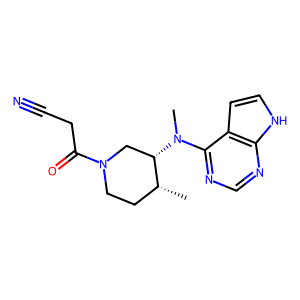

In [12]:
Query = Chem.MolFromSmiles('C[C@@H]1CCN(C(=O)CC#N)C[C@@H]1N(C)c1ncnc2[nH]ccc12') #Coordinates for 2D depiction are generated automatically
Draw.MolToImage(Query) 

## Ligand Based Virtual Screening

### 1. ChEMBL Similarity  Search

In [13]:
ID= 'CHEMBL221959'

similarity_url = f"https://www.ebi.ac.uk/chembl/api/data/similarity/{ID}/80"
similarity_request = requests.get(similarity_url, headers={"Accept":"application/json"}).json()
similarity_table = pd.DataFrame.from_dict(similarity_request['molecules'])[['molecule_chembl_id' , 'similarity',
                                                                            'max_phase','molecule_structures' ]]
similarity_table

,molecule_chembl_id,similarity,max_phase,molecule_structures
0,CHEMBL2103743,100,4,{'canonical_smiles': 'C[C@@H]1CCN(C(=O)CC#N)C[...
1,CHEMBL459769,100,0,{'canonical_smiles': 'C[C@H]1CCN(C(=O)CC#N)C[C...
2,CHEMBL459977,100,0,{'canonical_smiles': 'C[C@@H]1CCN(C(=O)CC#N)C[...
3,CHEMBL457871,100,0,{'canonical_smiles': 'C[C@H]1CCN(C(=O)CC#N)C[C...
4,CHEMBL234085,100,0,{'canonical_smiles': 'CC1CCN(C(=O)CC#N)CC1N(C)...


### 2. PubChem Similarity Search

In [14]:
name = "tofacitinib"
#we're going to search by name
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise ValueError(f"Could not find matches for compound: {name}") #  used to raise exceptions or errors
print(f"PubChem CID for {name} is:\n{cid}")

PubChem CID for tofacitinib is:
9926791


##### 2D Similarity Search

In [15]:
BASE_URL = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

url = BASE_URL +f"/compound/fastsimilarity_2d/cid/{cid}/cids/txt?Threshold=80"
res = requests.post(url)
Bidimensionalcids = res.text.split()

print("# Number of CIDs:", len(Bidimensionalcids))
print(Bidimensionalcids)

# Number of CIDs: 12863
['9926791', '44631938', '10174505', '118115473', '50914062', '59422203', '53344620', '5359620', '18008465', '118115983', '67066693', '59363349', '59198239', '53385838', '53341457', '49856703', '45275255', '23401507', '20111936', '18334366', '10351855', '9815628', '156404849', '122199230', '118911481', '72206804', '71138081', '58316756', '50913622', '50913620', '49855558', '45080217', '44380701', '25180101', '22282847', '11564772', '9966538', '5746216', '5466041', '4428602', '3047795', '151871061', '146013826', '145362469', '137653032', '137635761', '137346683', '136342279', '136227339', '136198876', '135962854', '135142442', '134611580', '134611545', '134537185', '134537167', '134537160', '134537158', '134537119', '134537114', '134537092', '134537085', '134537076', '134537061', '134537050', '134537033', '134537032', '127053794', '127053793', '127053790', '127053774', '126764334', '126647240', '126645320', '124203830', '123610694', '123131813', '122380305', '1189

In [16]:
url = BASE_URL +f"/compound/fastsimilarity_3d/cid/{cid}/cids/txt?Threshold=80"
res = requests.post(url)
Threedimensionalcids = res.text.split()

print("# Number of CIDs:", len(Threedimensionalcids))
print(Threedimensionalcids)

# Number of CIDs: 35
['9926791', '49856321', '49855554', '134537114', '118115950', '121493386', '50913915', '58293390', '10291730', '9818231', '50913623', '58293306', '53344620', '118911552', '49856318', '13492280', '118115706', '44380650', '137348619', '134537081', '118911587', '50913619', '118911482', '49856128', '134537067', '49856516', '134537152', '25009830', '53298849', '71620797', '134537033', '118911561', '118911585', '58293410', '134537092']


### 3. SwissSimilarity Search

We have performed a Simmilarity search in the SwissSimilarity web platform using _tofacitinib_ as the qeury molecule. We selected the CHEMBL database of active molecules (activity $ < 10 \mu M$) as the compound library and we combined 2D and 3D methods for the screening process. 

Then we download the results in a `csv` file (`ScreeningResults.csv`)

In [17]:
Database=pd.read_csv ('ScreeningResults.csv', delimiter=';', names =('ChemblID','Score','Smile'))
Database.shape[0], Database.shape[1]

(400, 3)

The Similarity Search has retrieved 400 compounds from the CHEMBL database of active compounds. 

In [18]:
Database.head()

,ChemblID,Score,Smile
0,CHEMBL221959,1.000,C[C@@H]1CCN(C[C@@H]1N(C)C1=C2C=CNC2=NC=N1)C(=...
1,CHEMBL459769,0.999,C[C@H]1CCN(C[C@H]1N(C)C1=C2C=CNC2=NC=N1)C(=O)...
2,CHEMBL4638316,0.999,CN(CC1CCCN1C1=C2C=CNC2=NC=N1)C(=O)CC#N
3,CHEMBL3689522,0.999,CC1CN(CC2(CCN2C(=O)CC#N)C1)C1=C2C=CNC2=NC=N1
4,CHEMBL3969009,0.999,CN(C1CCCN(C1)C1=C2C=CNC2=NC=N1)C(=O)CC#N


### Analysis of the results

We are going to analyze the similarity of the compounds obtained using fingerprints: 

- MACCS keys
- Morgan fingerprints 

#### MACCS Keys

In [19]:
#Calculate MACCS keys for tofacitinib
MACCQuery = MACCSkeys.GenMACCSKeys(Query)
MACCQuery.ToBitString()   

'00000000000000000000000000000000000000100100000000000000000000000100000000010101100101100000110011101100010010110001111011100100110011010110001001011111011110101111110'

In [20]:
#Calculate MACCS keys for all the compounds in the database of similar compounds
PandasTools.AddMoleculeColumnToFrame(Database, smilesCol='Smile') #Create ROMol column. If you are not able to see the molecules in the ROMOL column, restart the kernel.
Database.head(1)

,ChemblID,Score,Smile,ROMol
0,CHEMBL221959,1.0,C[C@@H]1CCN(C[C@@H]1N(C)C1=C2C=CNC2=NC=N1)C(=...,<rdkit.Chem.rdchem.Mol object at 0x7f5ace5a57b0>


In [21]:
MACCSDatabase = Database.ROMol.apply(MACCSkeys.GenMACCSKeys)
MACCSDatabase.head(5)

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ROMol, dtype: object

#### Morgan fingerprints


In [22]:
#Calculate Morgan fingerprints for tofacitinib
MorganQuery = rdFingerprintGenerator.GetFPs([Query])[0]
MorganQuery.ToBitString() 

'000000000000000000000000000000000000000000000000000100000000000000000000100000001000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000100000000100000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000001000000000100000000000000001000000000000000000000000000000000000000000000000000001000000000000000000000000000001000000000000000000000000000000000000000000000000000000000001010000000000000000000001000100000000000000000000000000000000100000000000000000000000000010000000000000000000000000000000000000000000000001010000000000000001100000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000001000000001000000000000000000000000000000000000000000000000000000000000000

In [23]:
#Calculate Morgan fingerprints for all molecules
MorganDatabase = rdFingerprintGenerator.GetFPs(Database["ROMol"].tolist())

#### Molecular Similarity Measures

Molecules can be compared using the MACCS keys and Morgan fingerprints that we have just calculated to assess their similarity. The most common similarity coefficients are the **Tanimoto coefficient** and the **Dice coefficient** so we are going to use them to compare the SwissSimilarity molecules with the query compound. 

In [24]:
def draw_ranked_molecules(molecules, sort_by_column):
    """
    Draw molecules sorted by a given column.

    Parameters
    ----------
    molecules : pandas.DataFrame
        Molecules (with "ROMol" and "name" columns and a column to sort by.
    sort_by_column : str
        Name of the column used to sort the molecules by.

    Returns
    -------
    Draw.MolsToGridImage
        2D visualization of sorted molecules.
    """

    molecules_sorted = molecules.sort_values([sort_by_column], ascending=False).reset_index()
    return Draw.MolsToGridImage(
        molecules_sorted["ROMol"],
        legends=[
            f"#{index+1}, similarity={molecule[sort_by_column]:.2f}"
            for index, molecule in molecules_sorted.iterrows()
        ],
        molsPerRow=3,
        subImgSize=(450, 150),
    )

##### MACCS keys

In [25]:
# Calculate similarty values between query and list elements
Database["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(MACCQuery, MACCSDatabase)
Database["dice_maccs"] = DataStructs.BulkDiceSimilarity(MACCQuery, MACCSDatabase)

In [26]:
#Sort by Tanimoto coefficient
preview = Database.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["ChemblID", "tanimoto_maccs", "dice_maccs"]]

,ChemblID,tanimoto_maccs,dice_maccs
0,CHEMBL221959,1.000000,1.000000
1,CHEMBL459769,1.000000,1.000000
2,CHEMBL1630794,0.962963,0.981132
3,CHEMBL4638316,0.945455,0.971963
4,CHEMBL1630800,0.945455,0.971963
...,...,...,...
395,CHEMBL3718883,0.434783,0.606061
396,CHEMBL307773,0.428571,0.600000
397,CHEMBL3717128,0.426471,0.597938
398,CHEMBL4078655,0.423077,0.594595


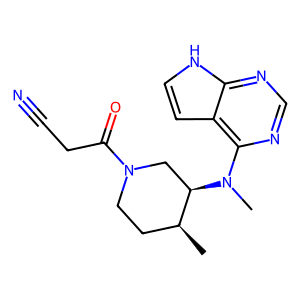

In [27]:
#Draw molecule with similarity index 1
#The smiles was retrieved from the ScreeningResults table
smiles= 'C[C@H]1CCN(C[C@H]1N(C)C1=C2C=CNC2=NC=N1)C(=O)CC#N'
QuerySimilarCompound = Chem.MolFromSmiles(smiles) #Coordinates for 2D depiction are generated automatically
Draw.MolToImage(QuerySimilarCompound)

In [28]:
#Draw second best molecule
draw_ranked_molecules(Database, "tanimoto_maccs")

Output hidden; open in https://colab.research.google.com to view.

##### Morgan fingerprints

In [29]:
Database["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(MorganQuery, MorganDatabase)
Database["dice_morgan"] = DataStructs.BulkDiceSimilarity(MorganQuery, MorganDatabase)

In [30]:
#Sort by Tanimoto coefficient
preview = Database.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["ChemblID", "tanimoto_morgan", "dice_morgan"]]

,ChemblID,tanimoto_morgan,dice_morgan
0,CHEMBL221959,1.000000,1.000000
1,CHEMBL459769,1.000000,1.000000
2,CHEMBL4224807,0.783333,0.878505
3,CHEMBL1630800,0.770492,0.870370
4,CHEMBL1630794,0.746032,0.854545
...,...,...,...
395,CHEMBL2420911,0.130952,0.231579
396,CHEMBL3717892,0.127907,0.226804
397,CHEMBL307773,0.123711,0.220183
398,CHEMBL297702,0.123596,0.220000


In [31]:
#Draw molecules
draw_ranked_molecules(Database, "tanimoto_morgan")

Output hidden; open in https://colab.research.google.com to view.

#### Exploratory Data Analysis

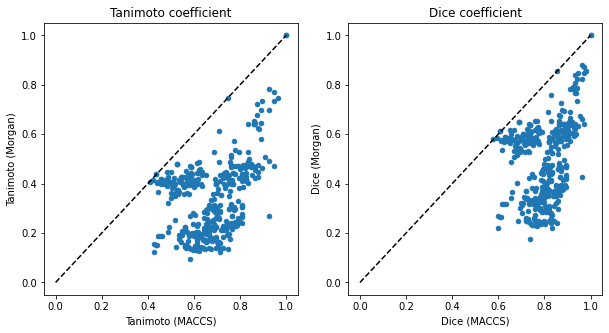

In [32]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
#Tanimoto coefficient
Database.plot("tanimoto_maccs", "tanimoto_morgan", kind="scatter", ax=ax[0])
ax[0].plot([0, 1], [0, 1], "k--")
ax[0].set_xlabel("Tanimoto (MACCS)")
ax[0].set_ylabel("Tanimoto (Morgan)")
ax[0].set_title("Tanimoto coefficient")

#Dice coefficient
Database.plot("dice_maccs", "dice_morgan", kind="scatter", ax=ax[1])
ax[1].plot([0, 1], [0, 1], "k--")
ax[1].set_xlabel("Dice (MACCS)")
ax[1].set_ylabel("Dice (Morgan)")
ax[1].set_title("Dice coefficient")


fig;

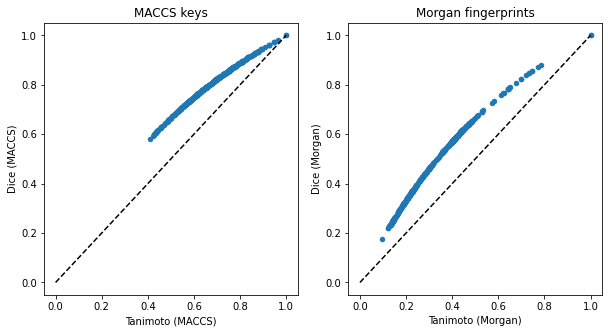

In [33]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

Database.plot("tanimoto_maccs", "dice_maccs", kind="scatter", ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--")
axes[0].set_xlabel("Tanimoto (MACCS)")
axes[0].set_ylabel("Dice (MACCS)")
axes[0].set_title("MACCS keys")

Database.plot("tanimoto_morgan", "dice_morgan", kind="scatter", ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--")
axes[1].set_xlabel("Tanimoto (Morgan)")
axes[1].set_ylabel("Dice (Morgan)")
axes[1].set_title("Morgan fingerprints")

fig;

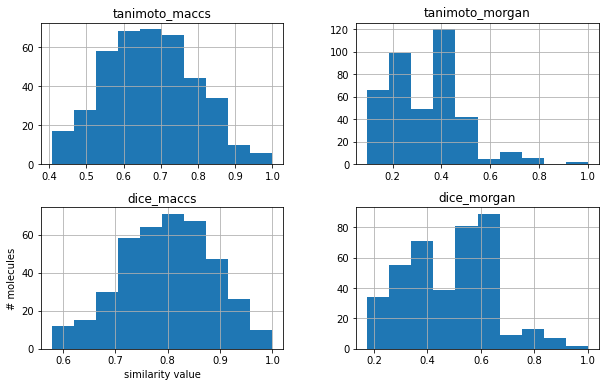

In [34]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
Database.hist(["tanimoto_maccs"], ax=axes[0, 0])
Database.hist(["tanimoto_morgan"], ax=axes[0, 1])
Database.hist(["dice_maccs"], ax=axes[1, 0])
Database.hist(["dice_morgan"], ax=axes[1, 1])
axes[1, 0].set_xlabel("similarity value")
axes[1, 0].set_ylabel("# molecules")
fig;

We usually consider two molecules to be similar if they have at least a Tanimoto coefficient above 80. However, we are going to lower this cut off value to increase the number of molecules for further analysis. 

In [35]:
cut_off = 0.7
Databasefilter = Database[Database['tanimoto_maccs']>= cut_off]
len(Databasefilter)

161

In [36]:
Databasefilter.to_csv('./similarityanalysis.csv', sep=';', index=False)